## Using Image_Segmentation lets Detect Brest Cancer

### Import Section


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from google.colab.patches import cv2_imshow
import glob
import pathlib
from tqdm import tqdm
tqdm.pandas()
! pip3 install -U segmentation-models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
from segmentation_models import Unet
tf.keras.backend.set_image_data_format('channels_last')
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
from segmentation_models.metrics import iou_score
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.backend as K

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 6.0 MB/s eta 0:00:00
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


## Lets download the data from kaggle

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!mkdir cancerdataset
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset
!unzip breast-ultrasound-images-dataset.zip -d cancerdataset
     


### Lets analyse the dataset and create a dataframe with the paths

In [3]:
data_dir = '/content/cancerdataset/Dataset_BUSI_with_GT/'
data_dir = pathlib.Path(data_dir)
all_files = list(data_dir.glob('*'))
all_files = [str(i) for i in all_files]

In [4]:
original_images = []
masked_images = []
for path in all_files:
  current_path_list = sorted([str(i) for i in list(pathlib.Path(path).glob('*'))])
  for path in tqdm(current_path_list):
    if '_mask' not in path:
      temp = path.replace('.png','_mask.png')
      if temp in current_path_list:
        original_images.append(path)
        masked_images.append(temp)

100%|██████████| 891/891 [00:00<00:00, 110857.73it/s]


In [5]:
len_check = len(original_images)
rand = np.random.choice(range(len_check))
print("original image path :",original_images[rand])
print("masked image path :",masked_images[rand])

original image path : /content/cancerdataset/Dataset_BUSI_with_GT/benign/benign (49).png
masked image path : /content/cancerdataset/Dataset_BUSI_with_GT/benign/benign (49)_mask.png


In [6]:
path_dataset = pd.DataFrame(data = np.column_stack((original_images,masked_images)),columns = ['Original_Image_Path','Masked_Image_Path'])
path_dataset = path_dataset.sample(frac=1, random_state=1).reset_index(drop = True)
path_dataset.head()

,Original_Image_Path,Masked_Image_Path
0,/content/cancerdataset/Dataset_BUSI_with_GT/be...,/content/cancerdataset/Dataset_BUSI_with_GT/be...
1,/content/cancerdataset/Dataset_BUSI_with_GT/be...,/content/cancerdataset/Dataset_BUSI_with_GT/be...
2,/content/cancerdataset/Dataset_BUSI_with_GT/be...,/content/cancerdataset/Dataset_BUSI_with_GT/be...
3,/content/cancerdataset/Dataset_BUSI_with_GT/be...,/content/cancerdataset/Dataset_BUSI_with_GT/be...
4,/content/cancerdataset/Dataset_BUSI_with_GT/be...,/content/cancerdataset/Dataset_BUSI_with_GT/be...


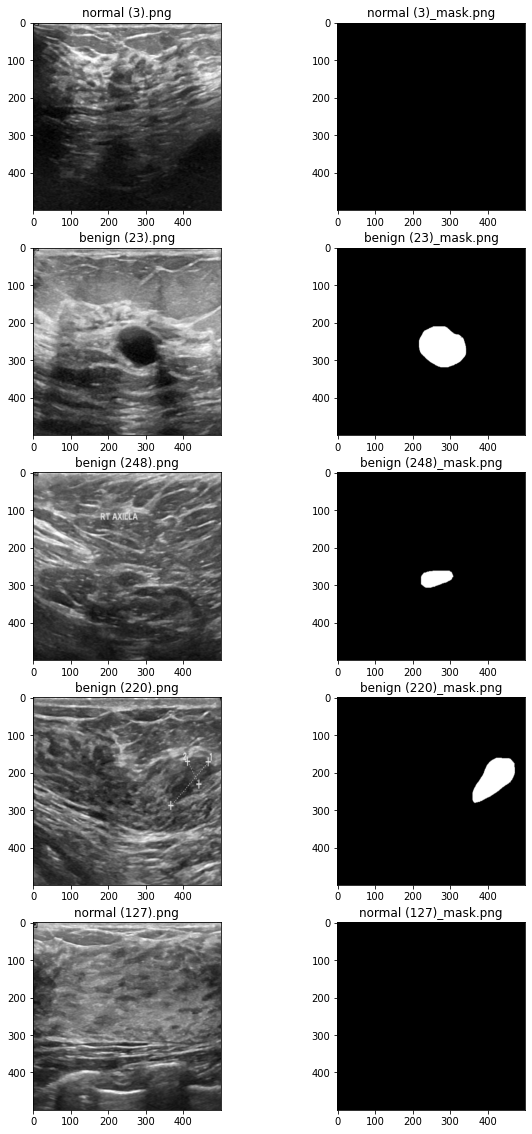

In [21]:
def visualize(images):
  fig = plt.figure(figsize=(10, 20))
  rows = len(images)
  columns = 2
  num = 1
  for j in range(rows):
    for i in range(len(images[j])):  
      ax = fig.add_subplot(rows, columns, num)
      image = cv2.imread(images[j][i])
      image = cv2.resize(image , (500 , 500))
      plt.imshow(image)
      ax.set_title(images[j][i].split('/')[-1])
      num+=1
  plt.show()
visualize(path_dataset.sample(n = 5).values)

## Lets do train and test split

In [22]:
X_train, X_test = train_test_split(path_dataset, test_size=0.20)

## Lets do image augmentation

In [23]:
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [24]:
def normalize_image(mask):
  mask = mask/255
  return mask

In [25]:
class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = ['Normal','Cancerous']
    # the parameters needs to changed based on your requirements
    def __init__(self, file_names, classes = None):
        self.w = 512
        self.h = 512
        self.ids = file_names
        # the paths of images
        self.images_fps   = [str(image_id) for image_id in self.ids['Original_Image_Path']]
        # the paths of segmentation images
        self.masks_fps    = [str(image_id) for image_id in self.ids['Masked_Image_Path']]
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls) for cls in classes]
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i],cv2.IMREAD_UNCHANGED) 
        #print(image.shape)
        image = cv2.resize(image,(self.w,self.h),interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = normalize_image(image)
        mask  = cv2.imread(self.masks_fps[i],cv2.IMREAD_GRAYSCALE)
        #print(mask.shape)
        mask = cv2.resize(mask,(self.w,self.h),interpolation=cv2.INTER_AREA)
        #print(mask.shape)
        mask = normalize_image(mask)
        #print(mask.shape)
        image_masks = [(mask == v) for v in self.class_values] # this line use unique color(that we speciified before as lable_clr) to seperate each class
        image_mask = np.stack(image_masks, axis=-1).astype('float')
        a = np.random.uniform()
        if a<0.2:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.4:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.6:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        elif a<0.8:
            image = aug5.augment_image(image)
            image_mask = image_mask
        else:
            image = aug6.augment_image(image)
            image_mask = aug6.augment_image(image_mask)
        #print(image.shape)
        #print(image_mask.shape)
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)
    

In [26]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [27]:
CLASSES = ['Normal','Cancerous']
BATCH_SIZE = 8
IMAGE_SHAPE = (512, 512, 3)
n_classes = len(CLASSES)   

In [28]:
train_dataset = Dataset(X_train, classes=CLASSES)
val_dataset  = Dataset(X_test, classes=CLASSES)

train_dataloader = Dataloder(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = Dataloder(val_dataset, batch_size = BATCH_SIZE, shuffle = True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, n_classes)

(8, 512, 512, 3)


In [29]:
tf.keras.backend.clear_session()
unet_model = Unet('densenet121', input_shape = IMAGE_SHAPE, classes = n_classes, activation = 'softmax', encoder_freeze = True,encoder_weights = 'imagenet')

29084464/29084464 [==============================] - 3s 0us/step


In [30]:
optim = tf.keras.optimizers.Adam(0.0001)
focal_loss = sm.losses.cce_dice_loss

In [31]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_iou_score'),
    ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=3),
    
]

In [32]:
train_steps = X_train.shape[0]//BATCH_SIZE
valid_steps = X_test.shape[0]//BATCH_SIZE
len(train_dataloader), train_steps

(78, 78)

In [33]:
unet_model.compile(optim, focal_loss, metrics=[iou_score])

In [34]:
unet_model_history = unet_model.fit(train_dataloader, steps_per_epoch = train_steps, epochs = 10,\
                                validation_data = val_dataloader, validation_steps = valid_steps,
                                callbacks = callbacks)

Epoch 1/10
78/78 [==============================] - 79s 778ms/step - loss: 0.7035 - iou_score: 0.4228 - val_loss: 0.7943 - val_iou_score: 0.3712 - lr: 1.0000e-04
Epoch 2/10
78/78 [==============================] - 54s 684ms/step - loss: 0.4942 - iou_score: 0.5527 - val_loss: 0.5743 - val_iou_score: 0.4969 - lr: 1.0000e-04
Epoch 3/10
78/78 [==============================] - 53s 683ms/step - loss: 0.4149 - iou_score: 0.6133 - val_loss: 0.5054 - val_iou_score: 0.5469 - lr: 1.0000e-04
Epoch 4/10
78/78 [==============================] - 54s 693ms/step - loss: 0.3573 - iou_score: 0.6585 - val_loss: 0.3964 - val_iou_score: 0.6404 - lr: 1.0000e-04
Epoch 5/10
78/78 [==============================] - 53s 677ms/step - loss: 0.3401 - iou_score: 0.6766 - val_loss: 0.3942 - val_iou_score: 0.6324 - lr: 1.0000e-05
Epoch 6/10
78/78 [==============================] - 53s 675ms/step - loss: 0.3263 - iou_score: 0.6848 - val_loss: 0.4050 - val_iou_score: 0.6258 - lr: 1.0000e-05
Epoch 7/10
78/78 [==========

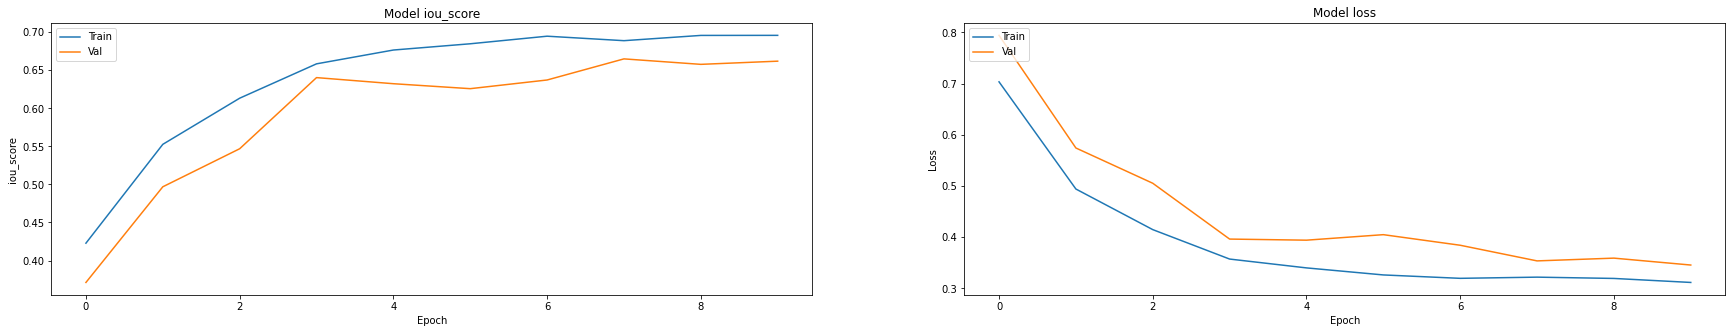

In [35]:


# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(unet_model_history.history['iou_score'])
plt.plot(unet_model_history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(unet_model_history.history['loss'])
plt.plot(unet_model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
     

In [36]:
images_ = X_test['Original_Image_Path'].values
masks_ = X_test['Masked_Image_Path'].values
lst = np.arange(len(images_))

1/1 [==============================] - 4s 4s/step


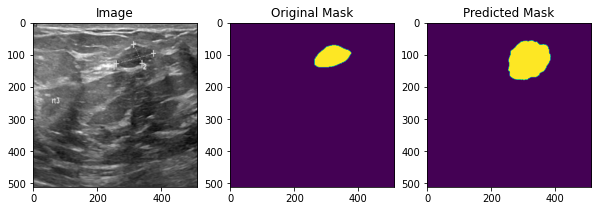

1/1 [==============================] - 0s 31ms/step


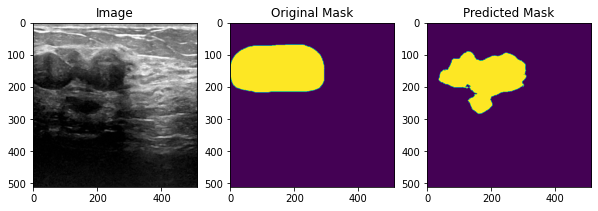

1/1 [==============================] - 0s 31ms/step


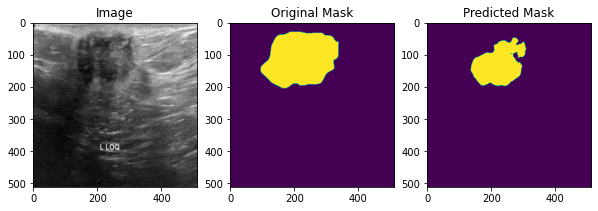

1/1 [==============================] - 0s 39ms/step


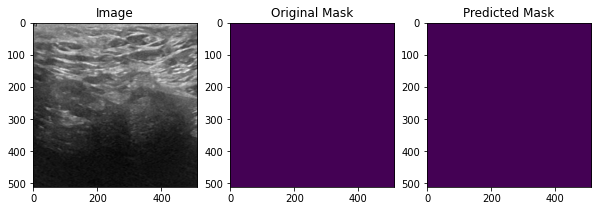

1/1 [==============================] - 0s 34ms/step


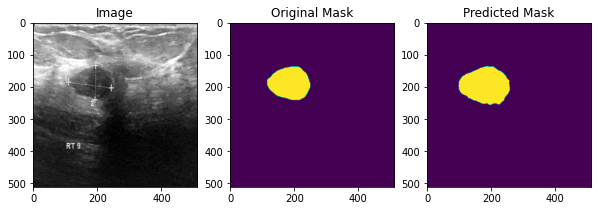

1/1 [==============================] - 0s 38ms/step


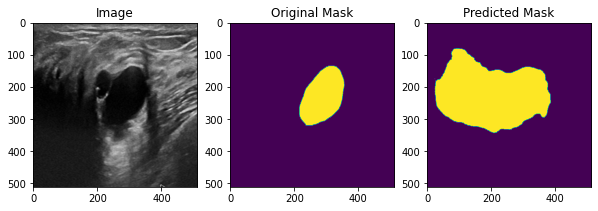

1/1 [==============================] - 0s 33ms/step


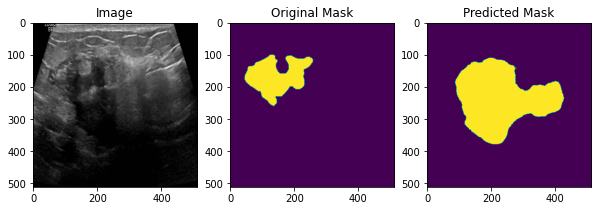

1/1 [==============================] - 0s 31ms/step


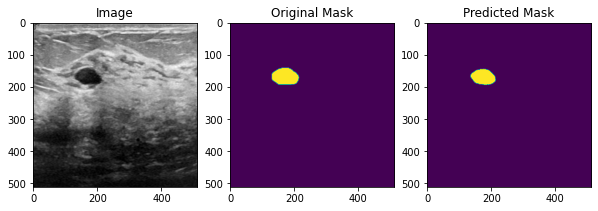

1/1 [==============================] - 0s 30ms/step


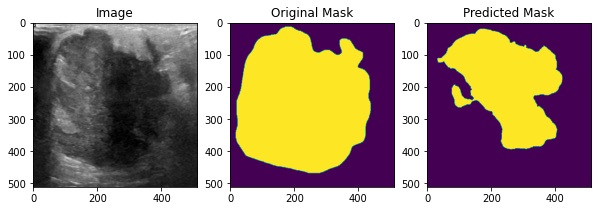

1/1 [==============================] - 0s 32ms/step


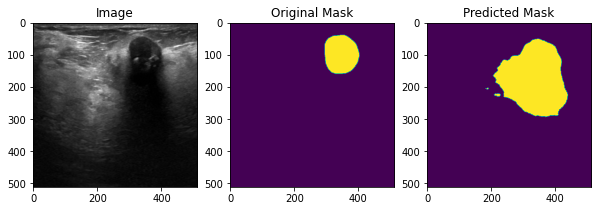

1/1 [==============================] - 0s 31ms/step


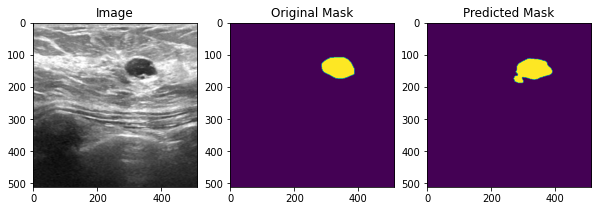

1/1 [==============================] - 0s 32ms/step


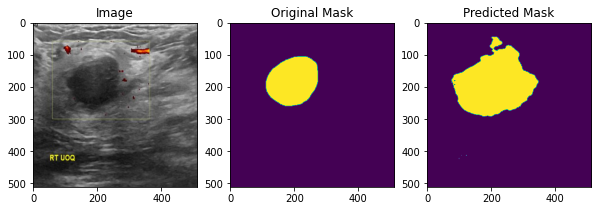

1/1 [==============================] - 0s 31ms/step


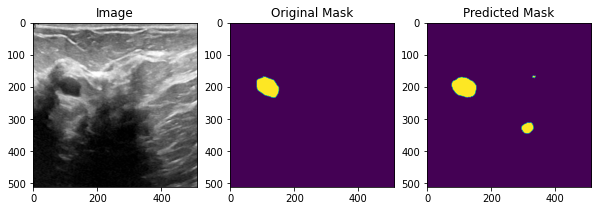

1/1 [==============================] - 0s 29ms/step


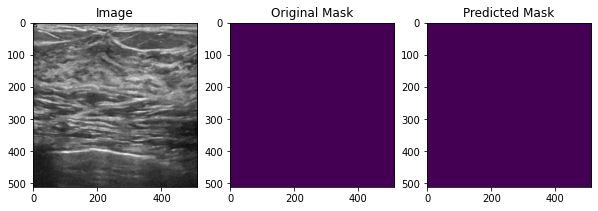

1/1 [==============================] - 0s 32ms/step


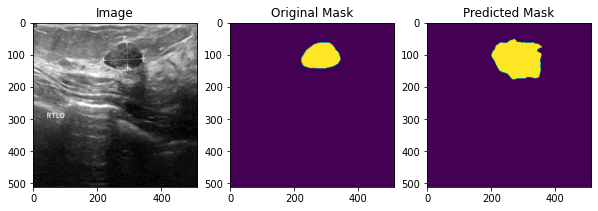

In [37]:
# Visualizing the predicted mask for val data.
import random
ids = np.random.choice(lst, size = 15, replace = False)
for i in ids:
  image = cv2.imread(images_[i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (512, 512),  interpolation = cv2.INTER_AREA)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = np.expand_dims(image, axis=0)
  image = image / 255
  mask  = cv2.imread(masks_[i], cv2.IMREAD_GRAYSCALE)
  mask = cv2.resize(mask, (512, 512),  interpolation = cv2.INTER_AREA)
  mask = mask / 255
  pred = unet_model.predict(image,verbose=1)
  pred = tf.argmax(pred, axis=-1)

  fig = plt.figure(figsize=(10,6))
  #plt.figure(figsize=(10,6))
  ax1 = fig.add_subplot(131)
  ax1.imshow(image[0,:,:])
  ax2=fig.add_subplot(132)
  ax2.imshow(mask)
  ax3=fig.add_subplot(133)
  ax3.imshow(pred[0,:,:])
  ax1.title.set_text('Image')
  ax2.title.set_text('Original Mask')
  ax3.title.set_text('Predicted Mask')
  plt.show()